# Collision Prediction

### Importing Libraries

In [2]:
# Standard libraries
import os
import gc
import glob
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

# Torchvision
from torchvision import transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from PIL import Image

# HuggingFace datasets
from datasets import load_dataset

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
                            confusion_matrix, roc_curve)

# Google Colab
from google.colab import drive
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

### Configs

In [3]:
# Parameters
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
NUM_FRAMES = 10
IMG_SIZE = 224
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
NUM_EPOCHS = 20

# Paths
BASE_TRAIN_DIR = "/content/collision_train_videos"
BASE_TEST_DIR = "/content/collision_test_videos"
train_zip_path = "/content/drive/MyDrive/collision_train_videos.zip"
test_zip_path  = "/content/drive/MyDrive/collision_test_videos.zip"
metadata_train_path = os.path.join(BASE_TRAIN_DIR, "metadata.csv")
metadata_test_path  = os.path.join(BASE_TEST_DIR, "metadata.csv")

os.makedirs(BASE_TRAIN_DIR, exist_ok=True)
os.makedirs(BASE_TEST_DIR, exist_ok=True)

<div dir="rtl">
متاسفانه محدودیت استفاده از GPU به اتمام رسید.
</div>

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


### Loading Data

In [27]:
train_ds = load_dataset("nexar-ai/nexar_collision_prediction", split="train")
test_ds = load_dataset("nexar-ai/nexar_collision_prediction", split="test")

Resolving data files:   0%|          | 0/1502 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1348 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1502 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1348 [00:00<?, ?it/s]

### Data EDA

In [28]:
print(train_ds)
print(test_ds)

Dataset({
    features: ['video', 'time_of_event', 'time_of_alert', 'light_conditions', 'weather', 'scene', 'time_to_accident'],
    num_rows: 1500
})
Dataset({
    features: ['video', 'time_of_event', 'time_of_alert', 'light_conditions', 'weather', 'scene', 'time_to_accident'],
    num_rows: 1344
})


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4>
مشاهده اولین فریم از یک ویدیو نمونه

<div dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
در این بخش، یک نمونه از دیتاست آموزشی انتخاب می‌شود و اولین فریم آن ویدیو استخراج و نمایش داده می‌شود.  
    
<div dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
    
- ابتدا نوع داده و تعداد فریم‌های ویدیو بررسی می‌شود.  
- در صورتی که فریم‌ها به صورت دیکشنری ذخیره شده باشند، تصویر واقعی استخراج می‌شود.  
- اگر فریم به صورت `PyTorch Tensor` باشد، به `NumPy` تبدیل می‌شود و ابعاد آن به `(ارتفاع، عرض، کانال)` تغییر داده می‌شود تا `matplotlib` بتواند آن را نمایش دهد.  
- مقادیر پیکسل‌ها به محدوده‌ی `[0, 1]` نرمال می‌شوند.  
- در نهایت فریم به همراه **زمان رویداد تصادف (Time of event)** نمایش داده می‌شود.


Video type: <class 'torchcodec.decoders._video_decoder.VideoDecoder'>
Number of frames: 1200


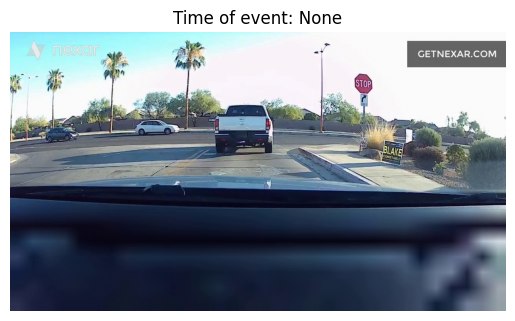

In [29]:
sample = train_ds[0]
video = sample["video"]
print("Video type:", type(video))
print("Number of frames:", len(video))
# ----------------------------------------------------
frame = video[0]
if isinstance(frame, dict):
    frame = frame.get("data", list(frame.values())[0])
if isinstance(frame, torch.Tensor):
    frame = frame.numpy()
if frame.ndim == 3 and frame.shape[0] in [3, 4]:
    frame = np.transpose(frame, (1, 2, 0))
if frame.max() > 1:
    frame = frame / 255.0
# ----------------------------------------------------
plt.imshow(frame)
plt.title(f"Time of event: {sample['time_of_event']}")
plt.axis("off")
plt.show()

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
در این بخش صرفا تلاش شد نمایی از فریم های دخیره شده برای سه نمونه رندوم تصادفی و غیر تصادفی نمایش داده شود.
</div>

In [37]:
def show_saved_frames(base_dir, label=1, num_videos=10):
    video_dirs = sorted(glob.glob(os.path.join(base_dir, f"video_*_label{label}")))
    selected_videos = random.sample(video_dirs, num_videos)

    fig, axes = plt.subplots(num_videos, 10, figsize=(20, 2*num_videos))

    for i, video_dir in enumerate(selected_videos):
        for j in range(10):
            frame_path = os.path.join(video_dir, f"F{j}_label{label}.png")

            if os.path.exists(frame_path):
                img = Image.open(frame_path)
                axes[i, j].imshow(img)
            else:
                axes[i, j].text(0.5, 0.5, "Missing", ha='center')

            axes[i, j].axis("off")

        axes[i, 0].set_ylabel(f"Video {i+1}", fontsize=12)

    plt.tight_layout()
    plt.show()

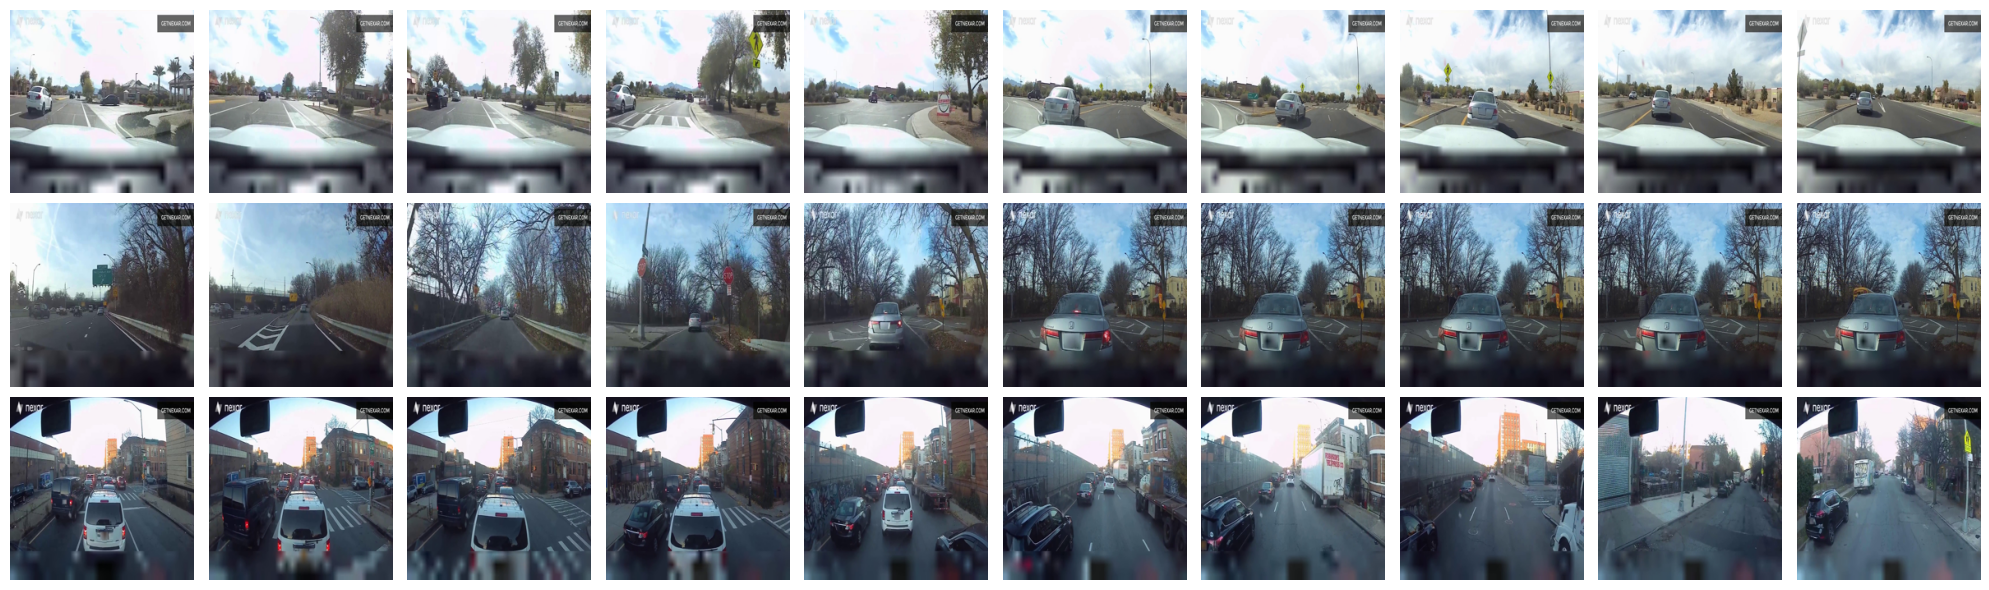

In [38]:
show_saved_frames(BASE_TRAIN_DIR, label=1, num_videos=3)

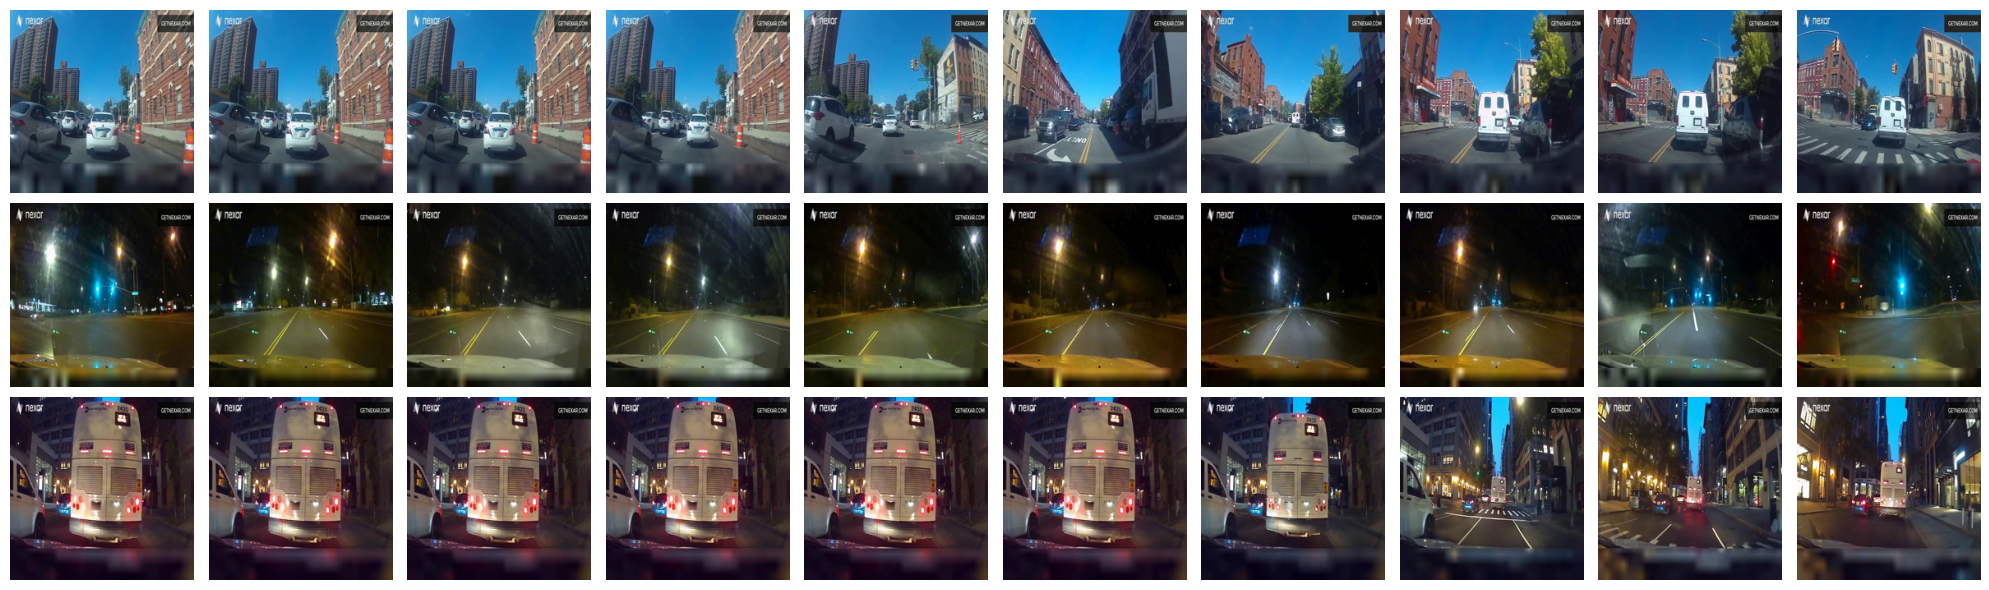

In [39]:
show_saved_frames(BASE_TRAIN_DIR, label=0, num_videos=3)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4>
استخراج و ذخیره‌سازی فریم‌ها  

<div dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
در این بخش، از هر ویدیو تعداد ۱۰ فریم با توزیع یکنواخت از ابتدا تا انتهای ویدیو استخراج شده است.  
سپس این ۱۰ فریم متناظر با هر ویدیو، در یک پوشه مجزا در مسیر Content ذخیره می‌شوند. 
ذخیره‌سازی فریم‌ها به‌منظور افزایش سرعت آموزش مدل امری ضروری است؛ زیرا در این حالت، مدل در فرآیند آموزش دسترسی سریع‌تر و مستقیم‌تری به داده‌ها خواهد داشت و در نتیجه، آموزش با کارایی و سرعت بالاتری انجام می‌شود.
فریم ها در این بخش به صورت  resize و normalize شده ذخیره میشود.

In [29]:
def extract_video_frames(dataset, base_dir, num_frames=10, img_size=224):
    os.makedirs(base_dir, exist_ok=True)

    for i, sample in enumerate(tqdm(dataset, desc=f"Extracting frames to {base_dir}")):
        label = int((sample['time_of_event'] is not None) and (not np.isnan(sample['time_of_event'])))
        video_dir = os.path.join(base_dir, f"video_{i:05d}_label{label}")
        os.makedirs(video_dir, exist_ok=True)

        video = sample['video']
        total_frames = len(video)
        indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

        for idx, frame_idx in enumerate(indices):
            frame = video[int(frame_idx)]
            if isinstance(frame, dict):
                frame = frame.get("data", list(frame.values())[0])
            if isinstance(frame, torch.Tensor):
                frame = frame.permute(1, 2, 0).cpu().numpy()
                if frame.max() > 1:
                    frame = (frame / 255.0)
                frame = (frame * 255).astype(np.uint8)

            img = Image.fromarray(frame)
            img = img.resize((img_size, img_size))
            img.save(os.path.join(video_dir, f"F{idx}_label{label}.png"))

In [30]:
extract_video_frames(
    dataset=train_ds,
    base_dir=BASE_TRAIN_DIR,
    num_frames=NUM_FRAMES,
    img_size=IMG_SIZE)

Extracting frames to /content/collision_train_videos:   0%|          | 0/1500 [00:00<?, ?it/s]

In [31]:
extract_video_frames(
    dataset=test_ds,
    base_dir=BASE_TEST_DIR,
    num_frames=NUM_FRAMES,
    img_size=IMG_SIZE)

Extracting frames to /content/collision_test_videos:   0%|          | 0/1344 [00:00<?, ?it/s]

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4>
ذخیره متادیتاها در کنار فریم‌ها


<div dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
از آنجایی که علاوه بر ویدیوها، مجموعه‌ای از ویژگی‌های کمکی نیز در اختیار داریم، تلاش شد تا این اطلاعات به‌عنوان <b>متادیتای مکمل</b> در کنار فریم‌های ویدیویی به مدل داده شوند تا قدرت تصمیم‌گیری آن افزایش یابد.
ویژگی‌های موجود شامل موارد زیر هستند:

<ul>
<li> وضعیت آب‌وهوا</li>
<li> وضعیت روشنایی</li>
<li> نوع صحنه (شهری، بزرگراه، روستایی و ...)</li>
<li> زمان وقوع حادثه (در صورت وجود تصادف)</li>
</ul>

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
در این میان، این ویژگی ها به دلیل ماهیت دسته‌ای (به جز زمان وقوع) (Categorical)، با استفاده از روش One-Hot Encoding به بردارهای عددی تبدیل شدند.
همچنین ویژگی <b>زمان وقوع حادثه</b> در صورت وجود، به صورت یک مقدار نرمال‌سازی‌شده عددی به بردار متادیتا افزوده شد.
در نهایت، این بردار متادیتا در کنار ویژگی‌های استخراج‌شده از فریم‌های ویدیویی، به مدل داده شد تا تصمیم‌گیری نهایی با در نظر گرفتن هر دو منبع اطلاعاتی انجام گیرد

In [40]:
def create_metadata_csv(dataset, base_dir, csv_path, num_videos=None):
    os.makedirs(base_dir, exist_ok=True)
    metadata = []

    if num_videos is not None:
        dataset = dataset.select(range(min(num_videos, len(dataset))))

    for i, sample in enumerate(dataset):
        label = int((sample['time_of_event'] is not None) and (not pd.isna(sample['time_of_event'])))
        video_dir = os.path.join(base_dir, f"video_{i:05d}_label{label}")
        metadata.append({
            'frames_path': video_dir,
            'label': label,
            'time_of_event': sample.get('time_of_event'),
            'light_conditions': sample.get('light_conditions'),
            'weather': sample.get('weather'),
            'scene': sample.get('scene')
        })

    df = pd.DataFrame(metadata)
    df.to_csv(csv_path, index=False)
    print(f"Saved metadata CSV: {csv_path}, rows: {len(df)}")

In [41]:
create_metadata_csv(train_ds, BASE_TRAIN_DIR, os.path.join(BASE_TRAIN_DIR, "metadata.csv"))
create_metadata_csv(test_ds, BASE_TEST_DIR, os.path.join(BASE_TEST_DIR, "metadata.csv"))

Saved metadata CSV: /content/collision_train_videos/metadata.csv, rows: 1500
Saved metadata CSV: /content/collision_test_videos/metadata.csv, rows: 1344


<div dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4>
ذخیره‌سازی فریم‌ها در گوگل درایو (جهت اطمینان و جلوگیری از حذف داده‌ها)

</div>

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
اگر در صورت ری استارت شدن سشن نیاز بود دیتا دوباره لود شود بهتر است فایل فریم ها و متادیتا روی درایو ذخیره شوند.
</div>

In [42]:
shutil.make_archive(base_name=train_zip_path.replace(".zip", ""), format='zip', root_dir=BASE_TRAIN_DIR)
shutil.make_archive(base_name=test_zip_path.replace(".zip", ""), format='zip', root_dir=BASE_TEST_DIR)

'/content/drive/MyDrive/collision_test_videos.zip'

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4>
ساخت دیتاست ویدیو به همراه متادیتا

<div dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
در این بخش یک کلاس سفارشی از `Dataset` ساخته شده است که هر نمونه را به صورت زیر آماده می‌کند:
    
* فریم‌های ویدیو
* اطلاعات محیطی (نور، آب‌وهوا، نوع صحنه، زمان رخداد)
* برچسب کلاس (تصادف / عدم تصادف)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
ابتدا اطلاعات از فایل CSV خوانده می‌شود. سپس متادیتای متنی (مانند وضعیت نور یا آب‌وهوا) با استفاده از One-Hot Encoding به بردار عددی تبدیل می‌شود تا برای مدل قابل استفاده باشد.
در متد `__getitem__` تمام فریم‌های هر ویدیو خوانده شده، به RGB تبدیل می‌شوند و در صورت وجود، transform روی آن‌ها اعمال می‌شود. در نهایت فریم‌ها به صورت یک تنسور با شکل `(T, C, H, W)` برگردانده می‌شوند.
خروجی هر نمونه به صورت رو به رو است:
(frames, meta, label)
این ساختار به مدل اجازه می‌دهد هم اطلاعات تصویری و هم شرایط محیطی را به طور همزمان یاد بگیرد.



In [6]:
class VideoFramesDatasetWithMeta(Dataset):
    def __init__(self, base_dir, metadata_csv, num_frames=NUM_FRAMES, transform=None):
        self.num_frames = num_frames
        self.transform = transform
        self.metadata = pd.read_csv(metadata_csv)
        self.video_dirs = self.metadata['frames_path'].tolist()
        self.labels = self.metadata['label'].tolist()

        # Preprocess metadata
        light_map   = {"Normal":0, "Twilight":1, "Dark":2}
        weather_map = {"Clear":0, "Rain":1, "Cloudy":2}
        scene_map   = {"Urban":0, "Highway":1, "Sub-urban":2, "Rural":3, "Other":4, "Industrial":5}

        self.meta_tensors = []
        for _, row in self.metadata.iterrows():
            light = [0]*len(light_map)
            weather = [0]*len(weather_map)
            scene = [0]*len(scene_map)
            if row['light_conditions'] in light_map:
                light[light_map[row['light_conditions']]] = 1
            if row['weather'] in weather_map:
                weather[weather_map[row['weather']]] = 1
            if row['scene'] in scene_map:
                scene[scene_map[row['scene']]] = 1
            time_event = [0.0] if pd.isna(row['time_of_event']) else [float(row['time_of_event'])/10.0]
            meta = light + weather + scene + time_event
            self.meta_tensors.append(torch.tensor(meta, dtype=torch.float32))

    def __len__(self):
        return len(self.video_dirs)

    def __getitem__(self, idx):
        video_dir = self.video_dirs[idx]
        label = self.labels[idx]
        meta = self.meta_tensors[idx]

        frames = []
        frame_files = sorted(glob.glob(os.path.join(video_dir, "*.png")))
        for f in frame_files:
            img = Image.open(f).convert("RGB")
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        frames = torch.stack(frames)  # (T, C, H, W)

        return frames, meta, label

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
پیش‌پردازش تصاویر

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
در این بخش قبل از ورود تصاویر به مدل، دو کار انجام می‌شود:
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
تبدیل تصویر به Tensor و نرمال‌سازی مقادیر پیکسل‌ها به بازه 0 تا 1
نرمال‌سازی کانال‌های RGB با میانگین و انحراف معیار استاندارد ImageNet
این کار باعث می‌شود داده‌ها استاندارد شوند و مدل سریع‌تر و پایدارتر آموزش ببیند، مخصوصاً اینکه ما داریم از مدل cnn pretrain شده استفاده میکنیم.

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

In [8]:
train_frames = VideoFramesDatasetWithMeta(BASE_TRAIN_DIR, metadata_train_path, num_frames=NUM_FRAMES, transform=transform)
test_frames  = VideoFramesDatasetWithMeta(BASE_TEST_DIR,  metadata_test_path,  num_frames=NUM_FRAMES, transform=transform)

train_size = int(0.8*len(train_frames))
val_size   = len(train_frames)-train_size
train_ds, val_ds = torch.utils.data.random_split(train_frames, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_frames, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
print("========== DATASET INFO ==========\n")

print("Type of train_frames:", type(train_frames))
print("Total videos in train_frames:", len(train_frames))

print("\n--- Single Sample (train_frames[0]) ---")
frames, meta, label = train_frames[0]

print("Frames shape (T, C, H, W):", frames.shape)
print("Meta shape:", meta.shape)
print("Label:", label)

print("\nMeta tensor values:")
print(meta)

print("\n========== SPLIT INFO ==========\n")
print("Train split size:", len(train_ds))
print("Validation split size:", len(val_ds))
print("Type of train_ds:", type(train_ds))

print("\n========== DATALOADER BATCH ==========\n")

batch_frames, batch_meta, batch_labels = next(iter(train_loader))

print("Batch Frames shape (B, T, C, H, W):", batch_frames.shape)
print("Batch Meta shape (B, meta_dim):", batch_meta.shape)
print("Batch Labels shape (B):", batch_labels.shape)

print("\nFirst sample in batch:")
print("Frames:", batch_frames[0].shape)
print("Meta:", batch_meta[0])
print("Label:", batch_labels[0])

========== DATASET INFO ==========

Type of train_frames: <class '__main__.VideoFramesDatasetWithMeta'>
Total videos in train_frames: 1500

--- Single Sample (train_frames[0]) ---
Frames shape (T, C, H, W): torch.Size([10, 3, 224, 224])
Meta shape: torch.Size([13])
Label: 0

Meta tensor values:
tensor([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

========== SPLIT INFO ==========

Train split size: 1200
Validation split size: 300
Type of train_ds: <class 'torch.utils.data.dataset.Subset'>

========== DATALOADER BATCH ==========

Batch Frames shape (B, T, C, H, W): torch.Size([8, 10, 3, 224, 224])
Batch Meta shape (B, meta_dim): torch.Size([8, 13])
Batch Labels shape (B): torch.Size([8])

First sample in batch:
Frames: torch.Size([10, 3, 224, 224])
Meta: tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
Label: tensor(0)


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=4>
مدل MobileNet + LSTM + Metadata

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
MobileNetV3 یک مدل شبکه عصبی کانولوشنی سبک برای استخراج ویژگی‌های تصویری است که با یادگیری الگوهایی مانند شکل اشیا، بافت و ساختار صحنه‌ها، معمولاً برای وظایف تشخیص و تحلیل تصویر استفاده می‌شود و روی دیتاست ImageNet آموزش دیده است.
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
مدل پایینی یک معماری ترکیبی برای تحلیل ویدیو است که از سه بخش تشکیل شده: ابتدا با استفاده از MobileNet از پیش‌آموزش‌دیده، از هر فریم ویدیو ویژگی‌های تصویری (مثل شکل خودروها و جاده) استخراج می‌شود سپس این ویژگی‌ها به LSTM داده می‌شوند تا تغییرات زمانی بین فریم‌ها (مثل نزدیک شدن خودروها یا الگوهای خطرناک) یاد گرفته شود؛ در ادامه، خروجی زمانی مدل با اطلاعات محیطی مانند نور، آب‌وهوا و نوع صحنه ترکیب می‌شود و در نهایت یک لایه Fully Connected تصمیم می‌گیرد که احتمال تصادف وجود دارد یا خیر. این معماری هم اطلاعات تصویری، هم الگوهای حرکتی و هم شرایط محیطی را به صورت همزمان در نظر می‌گیرد.

In [10]:
class MobileNet_LSTM_WithMeta(nn.Module):
    def __init__(self, hidden_dim=128, meta_dim=9, num_classes=2, freeze_cnn=True):
        super().__init__()

        # -------------------------------
        # CNN Backbone
        # -------------------------------
        # This part extracts visual features from each video frame.
        # It learns patterns such as vehicle shapes, road structure, and objects in the scene.
        self.cnn = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

        # Remove the original classification layer because we only need feature extraction
        self.cnn.classifier = nn.Identity()

        # If freeze_cnn=True, CNN weights are not updated during training
        # (Used only as a feature extractor in the first training phase)
        if freeze_cnn:
            for param in self.cnn.parameters():
                param.requires_grad = False

        # -------------------------------
        # LSTM
        # -------------------------------
        # This layer learns temporal relationships between video frames.
        # For example, it captures vehicle motion, approaching objects, and dangerous patterns over time.
        self.lstm = nn.LSTM(
            input_size=576,      # Feature vector size extracted from MobileNet for each frame
            hidden_size=hidden_dim,
            batch_first=True)

        # ---------------------------------------------
        # Fully Connected Layer: Final Decision Layer)
        # ---------------------------------------------
        # This layer combines temporal features and metadata information
        # to predict the final output (collision or non-collision)
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_dim + meta_dim, num_classes))

    def forward(self, frames, meta):
        # frames shape:
        # (Batch, Time, Channel, Height, Width)

        B, T, C, H, W = frames.shape

        # Flatten video batch for CNN feature extraction
        x = frames.view(B*T, C, H, W)

        # Extract visual features from each frame
        feats = self.cnn(x)  # Output shape: (B*T, 576)

        # Restore temporal sequence structure
        feats = feats.view(B, T, -1)  # (B, T, 576)

        # Learn temporal dependencies between frames
        # output , (hidden_state, cell_state)
        _, (h_n, _) = self.lstm(feats)

        # Use only the last hidden state of LSTM memory
        h_n = h_n.squeeze(0)  # (B, hidden_dim)

        # Combine temporal video features with environmental metadata
        x = torch.cat([h_n, meta], dim=1)

        # Final model output layer
        out = self.fc(x)

        return out

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
meta_dim = len(train_frames.meta_tensors[0])
model = MobileNet_LSTM_WithMeta(hidden_dim=128, meta_dim=meta_dim, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [12]:
history_dict = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'train_precision': [],
    'val_precision': [],
    'train_recall': [],
    'val_recall': []}


for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for frames, meta, labels in train_loader:
        frames, meta, labels = frames.to(device), meta.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(frames, meta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    # Validation
    model.eval()
    val_running, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for frames, meta, labels in val_loader:
            frames, meta, labels = frames.to(device), meta.to(device), labels.to(device)
            outputs = model(frames, meta)
            loss = criterion(outputs, labels)
            val_running += loss.item() * frames.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running / val_total
    val_acc  = val_correct / val_total

    history_dict['train_loss'].append(train_loss)
    history_dict['val_loss'].append(val_loss)
    history_dict['train_accuracy'].append(train_acc)
    history_dict['val_accuracy'].append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1 | Train Loss: 0.6859, Train Acc: 0.5333 | Val Loss: 0.6510, Val Acc: 0.6400
Epoch 2 | Train Loss: 0.6331, Train Acc: 0.6325 | Val Loss: 0.6102, Val Acc: 0.6833
Epoch 3 | Train Loss: 0.6082, Train Acc: 0.6625 | Val Loss: 0.5998, Val Acc: 0.6567
Epoch 4 | Train Loss: 0.5765, Train Acc: 0.7017 | Val Loss: 0.5704, Val Acc: 0.7133
Epoch 5 | Train Loss: 0.5601, Train Acc: 0.7317 | Val Loss: 0.5651, Val Acc: 0.7233
Epoch 6 | Train Loss: 0.5420, Train Acc: 0.7242 | Val Loss: 0.5448, Val Acc: 0.7333
Epoch 7 | Train Loss: 0.5228, Train Acc: 0.7467 | Val Loss: 0.5328, Val Acc: 0.7500
Epoch 8 | Train Loss: 0.4934, Train Acc: 0.7658 | Val Loss: 0.5295, Val Acc: 0.7333
Epoch 9 | Train Loss: 0.4807, Train Acc: 0.7775 | Val Loss: 0.5343, Val Acc: 0.7333
Epoch 10 | Train Loss: 0.4797, Train Acc: 0.7792 | Val Loss: 0.5135, Val Acc: 0.7333
Epoch 11 | Train Loss: 0.4623, Train Acc: 0.7850 | Val Loss: 0.5350, Val Acc: 0.7467
Epoch 12 | Train Loss: 0.4335, Train Acc: 0.8125 | Val Loss: 0.5036, Val A

In [13]:
torch.save(model.state_dict(), "model.pth")

In [14]:
all_labels = []
all_preds = []
all_probs = []

model.eval()
with torch.no_grad():
    for frames, meta, labels in test_loader:
        frames = frames.to(device)
        meta = meta.to(device)

        outputs = model(frames, meta)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.numpy()

        all_labels.extend(labels)
        all_preds.extend(preds)
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
ما میدانیم که داده‌ های Train و Test ما کاملا Balance هستند، یعنی نسبت ویدیوهای دارای تصادف و بدون تصادف در هر دو مجموعه تقریبا 50-50 است.
اگر یک مدل پایه (Baseline Model) در نظر بگیریم که هیچ چیزی یاد نگرفته باشد و صرفا کلاس اکثریت را پیشبینی کند:

<div dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
- این مدل به صورت تصادفی یا با استراتژی “همیشه یک کلاس را انتخاب کن” عمل می‌کند. 
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
- با توجه به اینکه نسبت کلاس‌ ها برابر است، کلاس اکثریت 50٪ مواقع درست خواهد بود.
<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=2>
بنابراین Accuracy این مدل در حالت بیس‌لاین تقریبا %50 خواهد بود.
این موضوع اهمیت تعادل داده‌ ها و انتخاب معیارهای دقیق تر مانند F1-Score و AUC را نشان میدهد، چرا که Accuracy تنها نمیتواند عملکرد واقعی مدل را در این حالت نشان دهد.

In [15]:
# Metrics
accuracy  = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall    = recall_score(all_labels, all_preds)
f1        = f1_score(all_labels, all_preds)
auc       = roc_auc_score(all_labels, all_probs)

print("Test Metrics")
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("AUC:", auc)

Test Metrics
Accuracy : 0.7269345238095238
Precision: 0.747163695299838
Recall: 0.6860119047619048
F1: 0.7152831652443755
AUC: 0.8075596123866213


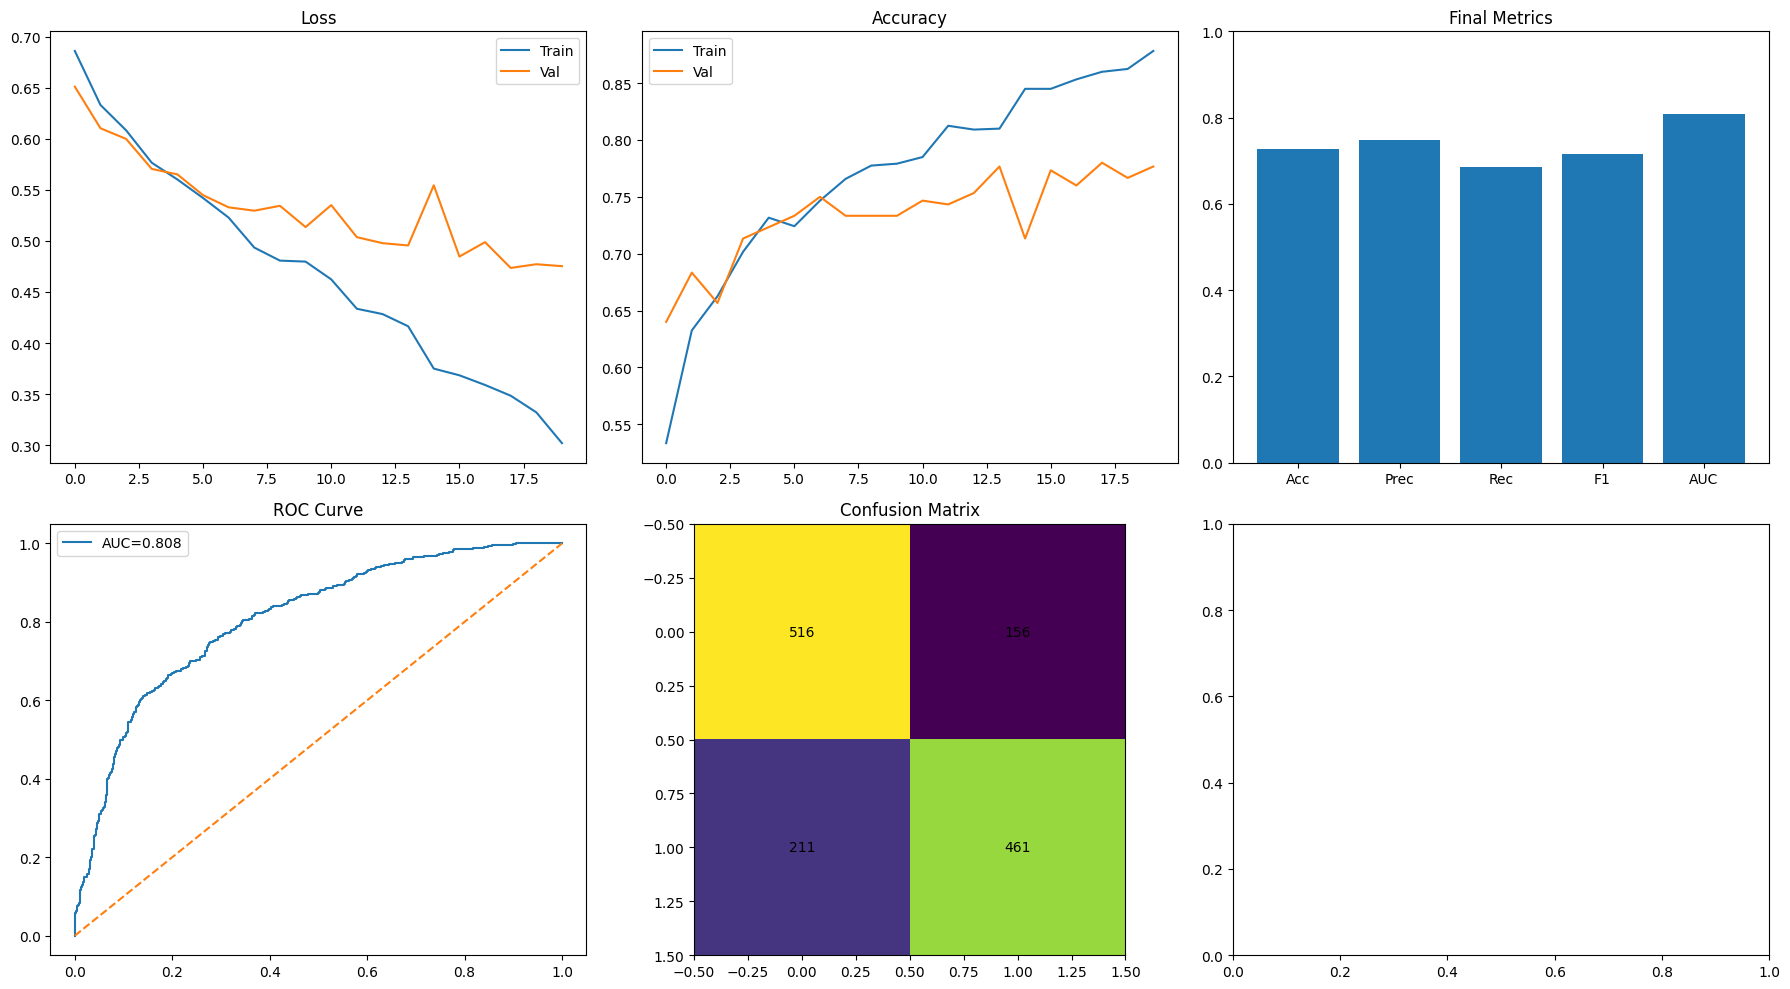

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history_dict['train_loss'], label='Train')
axes[0, 0].plot(history_dict['val_loss'], label='Val')
axes[0, 0].set_title("Loss")
axes[0, 0].legend()

# Accuracy
axes[0, 1].plot(history_dict['train_accuracy'], label='Train')
axes[0, 1].plot(history_dict['val_accuracy'], label='Val')
axes[0, 1].set_title("Accuracy")
axes[0, 1].legend()


# Bar metrics
metrics = ['Acc', 'Prec', 'Rec', 'F1', 'AUC']
values = [accuracy, precision, recall, f1, auc]
axes[0, 2].bar(metrics, values)
axes[0, 2].set_ylim(0, 1)
axes[0, 2].set_title("Final Metrics")

# ROC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
axes[1, 0].plot(fpr, tpr, label=f"AUC={auc:.3f}")
axes[1, 0].plot([0, 1], [0, 1], '--')
axes[1, 0].set_title("ROC Curve")
axes[1, 0].legend()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
axes[1, 1].imshow(cm)
axes[1, 1].set_title("Confusion Matrix")

for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, cm[i, j],
                        ha='center', va='center')

plt.tight_layout()
plt.show()

In [20]:
def show_test_samples(model, dataset, n_samples=5):
    model.eval()

    indices = random.sample(range(len(dataset)), n_samples)

    for idx in indices:
        frames, meta, label = dataset[idx]

        input_frames = frames.unsqueeze(0).to(device)
        input_meta   = meta.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_frames, input_meta)
            pred = torch.argmax(output, dim=1).item()
            prob = torch.softmax(output, dim=1)[0,1].item()

        fig, axes = plt.subplots(1, len(frames), figsize=(18,3))

        for i in range(len(frames)):
            img = frames[i].permute(1,2,0).cpu().numpy()

            mean = np.array([0.485, 0.456, 0.406])
            std  = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            axes[i].imshow(img)
            axes[i].axis("off")

        plt.suptitle(f"True Label: {label} | Predicted: {pred} | Prob Accident: {prob:.2f}", fontsize=14)
        plt.show()

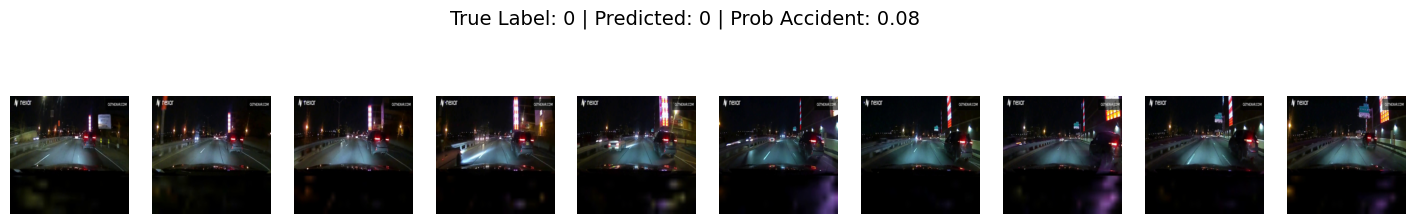

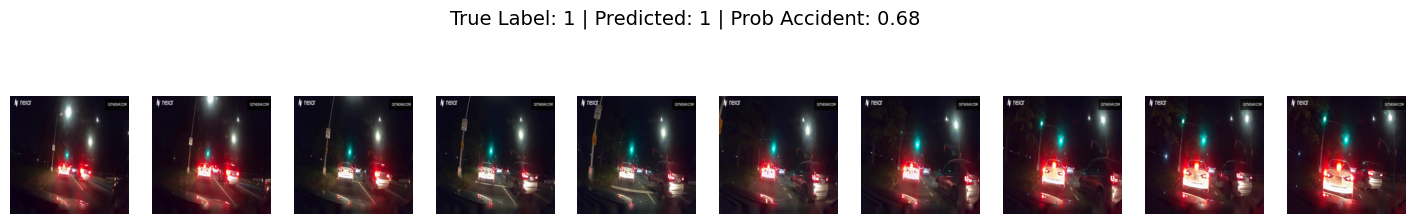

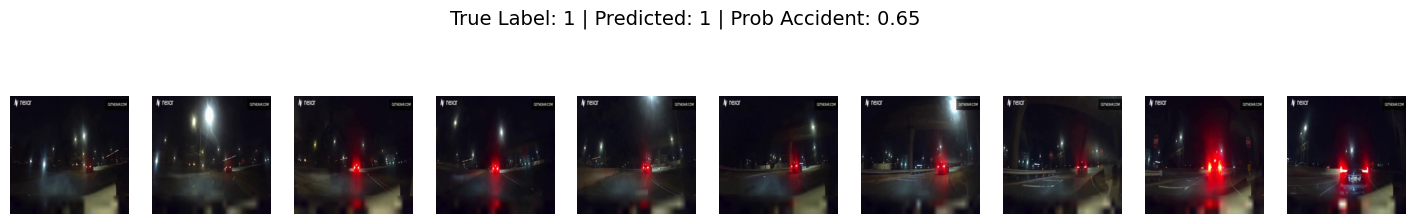

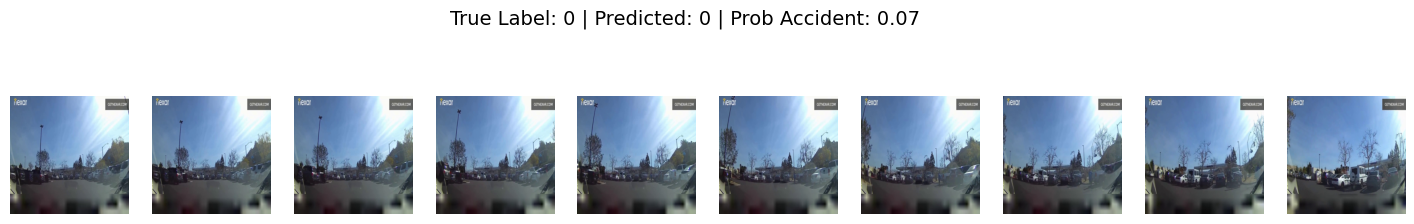

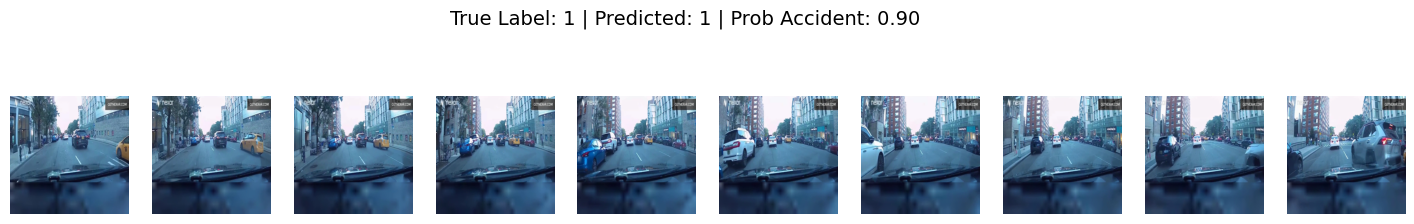

In [21]:
show_test_samples(model, test_frames, n_samples=5)